In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import save_image

import torchvision.datasets as datasets

## Autoencoder

![](pictures/autoencoder-architecture.png?raw=true)

$x,x' \in \mathbb{R}^D, z \in \mathbb{R}^d, d < D$

$x' = f(g(x))$

$Loss = d(x, x') = \Arrowvert x-x' \Arrowvert^{2} \rightarrow min_{\phi,\theta} $

![](pictures/autoencoder_schema.jpeg?raw=true)

Что  если мы хотим использовать **autoencoder** для порождения новых объектов $x$? хотим сгенерировать лицо или котика

$z \sim Law$ (случайный шум), $z \rightarrow Decoder \rightarrow x$

profit! (нет)

![](pictures/ae_fail.png?raw=true)

## VAE

Обычный autoencoder: $z = Encoder(x)$

VAE: $p(z|x) = Encoder(x),  z \sim p(z|x)$

$x \rightarrow Encoder \rightarrow p(z|x)$ (получаем параметры распределения $\overline\theta$, например $\mu$ и $\sigma$ для гауссиана )

$z \sim p(z|x) \rightarrow$ Decoder $\rightarrow x'$

то есть VAE в латентном пространстве выдает не один вектор, а целое распределение

Как это нам поможет порождать новых котиков?

Нам нужно попытаться сделать распределение $p(z|x)$ похоже на что то, что мы знаем, например на стандартный гауссиан

Как может получится:
<img src="pictures/norm.png" alt="drawing" width="500"/> 
А как нам хотелось бы:
<img src="pictures/norm1.png" alt="drawing" width="500"/>

Как этого добться? Нужно ввести регуляризатор на латентное распределение, чтобы оно было похоже на стандартное нормальное

Что в итоге VAE должен минимизировать?

$Loss = d(x,x') + \Omega(N(\mu(x), \sigma(x)), N(0, I)) \rightarrow min$

$Loss = \Arrowvert x-x' \Arrowvert^{2} + KL(N(\mu(x), \sigma(x)) \parallel N(0, I)) \rightarrow min$

### KL дивергенция

Расстояние Кульбака — Лейблера

$KL(q \parallel p) = \int \ln \dfrac qp q dx$

Свойства $KL$:

$KL(q \parallel p) \geq 0$

$KL(q \parallel p) \neq KL(p \parallel q)$

<img src="pictures/kl.pbm" alt="drawing" width="1000"/>

## Немного введения

### Формула Байеса

$P(A,B) = P(B)P(A|B)$

$P(A,B) = P(A)P(B|A)$

$P(B)P(A|B) = P(A)P(B|A)$

$P(A|B) = \dfrac{P(A)P(B|A)}{P(B)}$

### Вероятностные модели в МЛ

**Дискриминирующие модели:**

$x$ - картинка котика или песика

$x \rightarrow Model \rightarrow y \in$ {котик, песик}

Построили модель $p(y|x)$ (классификатор).

**Генеративные модели:**

А давайте бахнем сразу модель $p(x,y)$ или $p(x)$.

**В чем разница:**

Если мы знаем генеративную модель $p(x,y)$, то получить дискриминирующую $p(y|x)$ просто:

$p(y|x) = \dfrac{p(x,y)}{p(x)} \propto p(x,y)$

А наоборот, если знаем $p(y|x)$, получить $p(x,y)$ совсем не просто:

$p(x,y) = p(y|x)p(x)$, a $p(x)$ это распределение настоящих данных (например фотографий котиков), оно очень сложное, его мы не знаем

## Вероятностная модель генерации котиков (VAE)

**Decoder**:

$p(x,z) = p(z)p(x|z)$

$p(z) = N(0, I)$, 
$p(x|z)$ - Decoder

**Encoder**:

Реализует вероятностную модель $p(z|x)$

По формуле Байеса:

$p(z|x) = \dfrac{p(z)p(x|z)}{p(x)}$

Проблема: $p(x)$ очень сложное распределение, это распределение настоящих фотографий котиков

Решение:

$p(z|x) \approx q(z) = N(\mu, \sigma)$

$\mu = \mu(x), \sigma = \sigma(x)$. Будем их параметризовать нейронной сетью.

### Вариационное приближение

\begin{equation*}
p(x,z) = p(x)p(z|x) \\
\log p(x,z) = \log p(x) + \log p(z|x) \\
\log p(x) = \log p(x,z) - \log p(z|x) \\ 
\mathbb{E}_{q(z)} \log p(x) = \int q(z)\log p(x,z)dz - \int q(z)\log p(z|x)dz \\
\log p(x) = \int q(z)\log p(x,z)dz - \int q(z)\log p(z|x)dz - \int q(z) \log q(z)dz + \int q(z) \log q(z)dz \\
\log p(x) = \int q(z)\log \dfrac{p(x,z)}{q(z)}dz + \int q(z) \log \dfrac{q(z)}{p(z|x)}dz\\
const = L(q) + KL(q \parallel p(z|x)) \\
KL(q \parallel p(z|x)) \rightarrow min \Rightarrow L(q) \rightarrow max \\
L(q) = \int q(z)\dfrac{p(x,z)}{q(z)}dz = \int q(z) \log \dfrac{p(z)p(x|z)}{q(z)}dz
\end{equation*}
Тут $p(z)$ наше априорное распределение: $N(0, I)$ 
\begin{equation*}
L(q) = \int q(z) \log p(x|z) dz - \int q(z) \log \dfrac {q(z)}{p(z)} dz \\
L(q) = \mathbb{E}_{q(z)} \log p(x|z) - KL(q \parallel p)
\end{equation*}

$x \rightarrow Encoder \rightarrow p(z|x) \approx q(z)$. 

$z \sim q(z), z \rightarrow Decoder \rightarrow \log p(x|z)$

$\mathbb{E}_{q(z)} \log p(x|z)$ - правдоподобие

$KL(q \parallel p)$ - регуляризатор

Вариационный вывод говорит о том, что мы правильно выбрали KL диввергенцию и именно в эту сторону в качестве регуляризатора

Если предположить, что $p(x|z)$ гауссиан: $p(x|z) = N(f(z), \sigma I)$, где $f(\cdot)$ это Decoder

$\log p(x|z) = - \dfrac{1}{2 \sigma} \Arrowvert x - f(z) \Arrowvert^2$

$Loss = \dfrac{1}{2 \sigma} \Arrowvert x - f(z) \Arrowvert^2 + KL(q_x(z) \parallel p(z))$

$q_x(z) = N(z|\mu(x), \sigma(x))$

$KL(N(\mu, \sigma I) \parallel N(0,I) = \int N(\mu, \sigma I) \log \dfrac{N(\mu, \sigma I)}{N(0,I)}dx = -\dfrac{1}{2}\sum_i(1 - \log \sigma^2_i - \mu^2_i - \sigma^2_i)$

$Loss = c\Arrowvert x - f(z) \Arrowvert^2 - \dfrac{1}{2}\sum_i(1 - \log \sigma^2_i - \mu^2_i - \sigma^2_i)\rightarrow min_{f,\mu, \sigma}$

Теперь можно параметризовать $\mu(x)$ и $\sigma(x)$ нейронными сетями

![](pictures/vae2.png?raw=true)

Как протащить градиент через процесс сэмплирования?

Ответ: **reparameterization trick**

Любую нормлаьно распределенную случайную велечину $z \sim N(\mu, \sigma I)$ можно представить, как:

$z = \mu + \sigma \odot \epsilon$

$\epsilon \sim N(0, I)$

Тоесть мы как бы на вход сети подаем экземпляр $x \sim P_{Data}$ и $\epsilon \sim N(0, I)$

## Пример

In [6]:
image_size = 28
image_shape = (1, image_size, image_size)

batch_size = 64
fashionloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "data/mnist",
        train=True,
        download=True,
        transform=transforms.ToTensor(),
    ),
    batch_size=batch_size,
    shuffle=True,
)
fashiontestloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "data/mnist",
        train=False,
        download=True,
        transform=transforms.ToTensor(),
    ),
    batch_size=batch_size,
    shuffle=False,
)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) 
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2).to(device)

In [9]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [10]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [11]:
def train(epoch, dataloader=fashionloader, testloader=fashiontestloader, sample_dir=None, show_test_loss=False):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    if show_test_loss:
        vae.eval()
        test_loss=0
        with torch.no_grad():
            for data, _ in testloader:
                data = data.to(device)
                recon, mu, log_var = vae(data)
                test_loss += loss_function(recon, data, mu, log_var).item()
        print('\tepoch %2d\ttrain set loss %.4f\ttest set loss %.4f' % (epoch, train_loss / len(dataloader.dataset), test_loss / len(testloader.dataset)))
    else:
        print('\tepoch %d\taverage loss %.4f' % (epoch, train_loss / len(dataloader.dataset)))
    
    if sample_dir is not None:
        with torch.no_grad():
            z = torch.randn(25, 2).to(device)
            sample = vae.decoder(z).to(device)
            save_image(sample.view(25, 1, 28, 28), "%s/%02d.png" % (sample_dir, epoch), nrow=5, normalize=True)
            
            plt.figure(figsize=(6,6))
            img = mpimg.imread("%s/%02d.png" % (sample_dir, epoch))
            imgplot = plt.imshow(img)
            plt.show()

	epoch  1	train set loss 279.6751	test set loss 268.9951


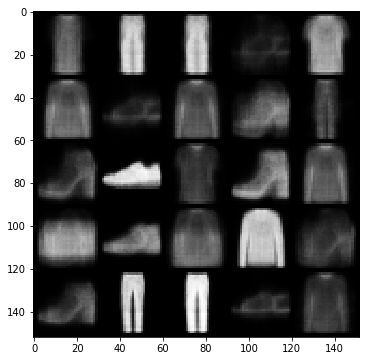

	epoch  2	train set loss 265.0450	test set loss 265.0916


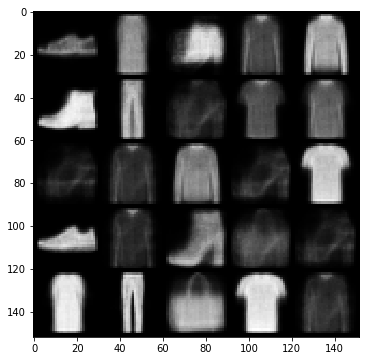

	epoch  3	train set loss 262.1927	test set loss 263.2719


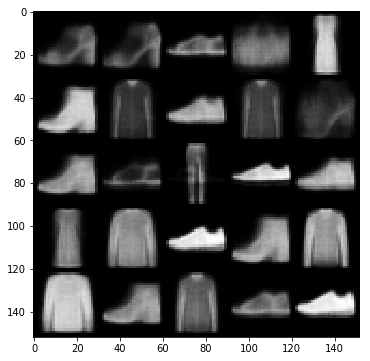

	epoch  4	train set loss 260.5633	test set loss 261.5955


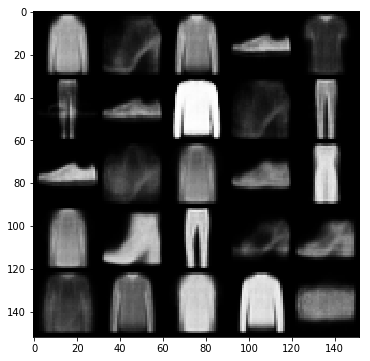

	epoch  5	train set loss 259.6099	test set loss 261.1175


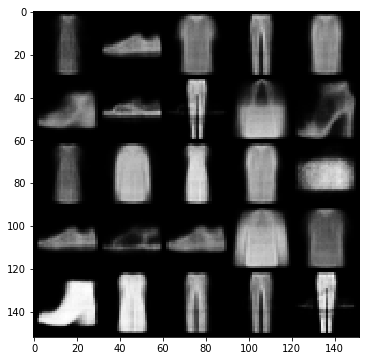

	epoch  6	train set loss 258.7068	test set loss 259.6749


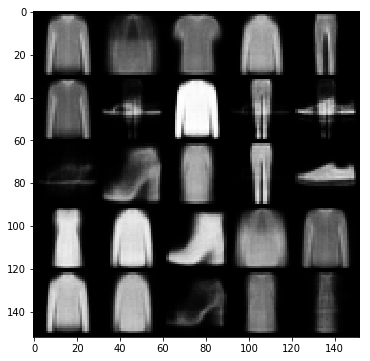

KeyboardInterrupt: 

In [12]:
for epoch in range(1, 16):
    train(epoch, sample_dir='samples', show_test_loss=True)